In [1]:
import sys
sys.path.append('../../..')
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
import numpy as np
import xarray as xr
import random as rd
import platform
import adamod
import torch
import torch.nn as nn
import torch.nn.functional as F


from torch.utils.data import DataLoader
from collections import OrderedDict
from torch.nn.parameter import Parameter
import matplotlib.pyplot as plt
from MogrifierLSTM import MogrifierLSTMCell
from utils.dataset import NCDFDatasets
from utils.evaluator import Evaluator
from utils.trainer import Trainer
from datetime import datetime

In [57]:
a = torch.rand(2,1,5,5,5)
b = torch.rand(2,1,5,5)
print(a[0,0])
print(b)
print(a+b)

tensor([[[[[0.1034, 0.1503, 0.8956, 0.5046, 0.8306],
           [0.6752, 0.4638, 0.3125, 0.0505, 0.1119],
           [0.2502, 0.3735, 0.7533, 0.6606, 0.0956],
           [0.9447, 0.0180, 0.3351, 0.9352, 0.6268],
           [0.5639, 0.8840, 0.9122, 0.4781, 0.8257]],

          [[0.6745, 0.6249, 0.1661, 0.9993, 0.5569],
           [0.1276, 0.6700, 0.5555, 0.2754, 0.6142],
           [0.2231, 0.5865, 0.1867, 0.4688, 0.3718],
           [0.2567, 0.5129, 0.5077, 0.5084, 0.5969],
           [0.3625, 0.2308, 0.8606, 0.5368, 0.8870]],

          [[0.8506, 0.5613, 0.7084, 0.2811, 0.4866],
           [0.2776, 0.7026, 0.1618, 0.7925, 0.3273],
           [0.9490, 0.1727, 0.4457, 0.7533, 0.0709],
           [0.2931, 0.6828, 0.9628, 0.3459, 0.9354],
           [0.4749, 0.4404, 0.9677, 0.3250, 0.8181]],

          [[0.0901, 0.9698, 0.2329, 0.4051, 0.8321],
           [0.2983, 0.1429, 0.4683, 0.9786, 0.9303],
           [0.2776, 0.8904, 0.4570, 0.6446, 0.9918],
           [0.6346, 0.8899, 0.8017, 0.48

In [54]:
x = torch.rand(2,3,4)
#print(x)
print(x[:,-2:,:])
y = x[:,-2:,:]
y = y.permute(0,2,1).contiguous().view(-1, 2);
print(y.size())
print(y)
linear = torch.nn.Linear(2, 1)
z = linear(y)
print(z)
print(z.size())
z = z.view(-1, 4)
print(z.size())
print(z)

tensor([[[0.5346, 0.6534, 0.4863, 0.8312],
         [0.3723, 0.3540, 0.6590, 0.0186]],

        [[0.3766, 0.5057, 0.7978, 0.9456],
         [0.6688, 0.3858, 0.2000, 0.6071]]])
torch.Size([8, 2])
tensor([[0.5346, 0.3723],
        [0.6534, 0.3540],
        [0.4863, 0.6590],
        [0.8312, 0.0186],
        [0.3766, 0.6688],
        [0.5057, 0.3858],
        [0.7978, 0.2000],
        [0.9456, 0.6071]])
tensor([[0.9726],
        [1.0069],
        [1.1437],
        [0.8541],
        [1.1073],
        [0.9702],
        [0.9612],
        [1.2890]], grad_fn=<AddmmBackward>)
torch.Size([8, 1])
torch.Size([2, 4])
tensor([[0.9726, 1.0069, 1.1437, 0.8541],
        [1.1073, 0.9702, 0.9612, 1.2890]], grad_fn=<ViewBackward>)


In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device
if (torch.cuda.is_available()):
    torch.cuda.empty_cache()

In [4]:
batch_size = 25
validation_split = 0.2
test_split = 0.2
param = {'encoder_layer_size': 3, 'decoder_layer_size': 3, 'kernel_size': 5, 'filter_size': 32}

In [5]:
import xarray as xr
data_path = '../../../data/dataset-ucar-1979-2015-seq5-ystep5.nc'
dataset = xr.open_dataset(data_path)
print(dataset)

<xarray.Dataset>
Dimensions:  (channel: 1, lat: 32, lon: 32, sample: 54047, time: 5)
Coordinates:
  * lat      (lat) int32 -54 -52 -50 -48 -46 -44 -42 -40 ... -6 -4 -2 0 2 4 6 8
  * lon      (lon) int32 278 280 282 284 286 288 290 ... 330 332 334 336 338 340
Dimensions without coordinates: channel, sample, time
Data variables:
    x        (sample, time, lat, lon, channel) float32 ...
    y        (sample, time, lat, lon, channel) float32 ...
Attributes:
    description:  The variables have air temperature values and are separable...


In [6]:
data = NCDFDatasets(dataset, val_split = 0.2, test_split = 0.2)
train_data = data.get_train()
val_data = data.get_val()
test_data = data.get_test()

In [7]:
print("-----Train-----")
print("X : ", train_data.x.shape)
print("Y : ", train_data.y.shape)
print("-----Val-----")
print("X : ", val_data.x.shape)
print("Y : ", val_data.y.shape)
print("-----Test-----")
print("X : ", test_data.x.shape)
print("Y : ", test_data.y.shape)

-----Train-----
X :  torch.Size([32429, 1, 5, 32, 32])
Y :  torch.Size([32429, 1, 5, 32, 32])
-----Val-----
X :  torch.Size([10809, 1, 5, 32, 32])
Y :  torch.Size([10809, 1, 5, 32, 32])
-----Test-----
X :  torch.Size([10809, 1, 5, 32, 32])
Y :  torch.Size([10809, 1, 5, 32, 32])


In [8]:
seed = 1000
np.random.seed(seed)
rd.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic=True

def init_seed(seed):
    np.random.seed(seed)
    
init_seed = init_seed(seed)

In [9]:
params = {'batch_size': batch_size,
          'num_workers': 4,
          'worker_init_fn': init_seed}

train_loader = DataLoader(dataset=train_data, shuffle=True, **params)
val_loader = DataLoader(dataset=val_data, shuffle=False, **params)
test_loader = DataLoader(dataset=test_data, shuffle=False, **params)

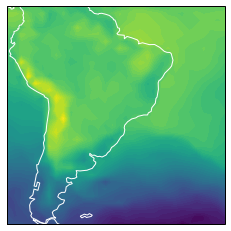

In [10]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import cartopy
#sample, ch, time, lat, lon
sst = train_data.y[0, 0, 0, :, :]
lats = dataset.variables['lat'][:]
lons = dataset.variables['lon'][:]

ax = plt.axes(projection=ccrs.PlateCarree())

plt.contourf(lons, lats, sst, 60,
             transform=ccrs.PlateCarree())
ax.coastlines(color='white')

plt.show()

In [102]:
import math
class Grid(object):
    def __init__(self, d1, d2, device, ratio = 0.5):
        self.d1 = d1
        self.d2 = d2
        self.ratio = ratio
        self.device = device

    def __call__(self, x):
        h = x.shape[2]
        w = x.shape[3]
        z = x.shape[1]
        
        st_s = np.random.randint(z)
        step_s = np.random.randint(1,3)
        x_temp = x.clone()
        
        mask_cube = torch.ones(z,h,w).to(device)
        
        d = np.random.randint(self.d1, self.d2)
        d = 8
        self.l = math.ceil(d*self.ratio)
        # 1.5 * h, 1.5 * w works fine with the squared images
        # But with rectangular input, the mask might not be able to recover back to the input image shape
        # A square mask with edge length equal to the diagnoal of the input image 
        # will be able to cover all the image spot after the rotation. This is also the minimum square.
        hh = math.ceil((math.sqrt(h*h + w*w)))
        
        for j in range(z):

            mask = np.ones((hh, hh), np.float32)
            st_h = np.random.randint(d)
            st_w = np.random.randint(d)


            for i in range(-1, hh//d+1):
                    s = d*i + st_h
                    t = s+self.l
                    s = max(min(s, hh), 0)
                    t = max(min(t, hh), 0)
                    #print(s)
                    #print(t)
                    mask[s:t,:] *= 0
            for i in range(-1, hh//d+1):
                    s = d*i + st_w
                    t = s+self.l
                    s = max(min(s, hh), 0)
                    t = max(min(t, hh), 0)
                    mask[:,s:t] *= 0
                    
            mask = np.asarray(mask)
            mask = mask[(hh-h)//2:(hh-h)//2+h, (hh-w)//2:(hh-w)//2+w]
            
            mask = torch.from_numpy(mask).float().to(self.device)
            mask = 1-mask
            mask = mask.expand(h,w)
            mask_cube[j] = mask
            #x_temp[:,j,:,:] = x[:,j,:,:] * mask 
        #x[0,0,31,:]*= 0
        print(mask_cube[0].shape)
        return x*mask_cube, mask_cube[0]
    
class GridMask(nn.Module):
    def __init__(self, d1, d2, device, ratio = 0.5, prob=1., max_epoch = 10, mode=0):
        super(GridMask, self).__init__()
        self.ratio = ratio
        self.mode = mode
        self.st_prob = prob
        self.max_epoch = max_epoch
        self.grid = Grid(d1, d2, device, ratio)

    def set_prob(self, epoch):
        self.grid.set_prob(epoch, self.max_epoch)

    def forward(self, x):
        if not self.training:
            return x
        c,s,h,w = x.size()
        y = []
        y_s = []
        #for i in range(n):
        z, mask = self.grid(x)
        y.append(z)
        y = torch.cat(y).view(c,s,h,w)
        return y, mask

In [103]:
for i, (x, y) in enumerate(train_loader):
    z = x[0]
    break

In [104]:
grid = GridMask(3,20, device, ratio=0.8)
y, mask = grid(z.to(device))

torch.Size([32, 32])


[]

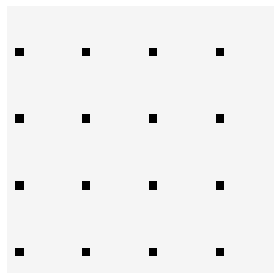

In [105]:
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np
# make a color map of fixed colors
cmap = colors.ListedColormap(['black', 'whitesmoke'])
bounds=[0,0.5,1]
norm = colors.BoundaryNorm(bounds, cmap.N)
# tell imshow about color map so that only set colors are used

#fig = plt.figure(figsize=(5, 100))
plt.imshow(mask.cpu(), interpolation='none', cmap=cmap, norm=norm, origin='lower')
plt.axis('off')
plt.tight_layout()
plt.plot()

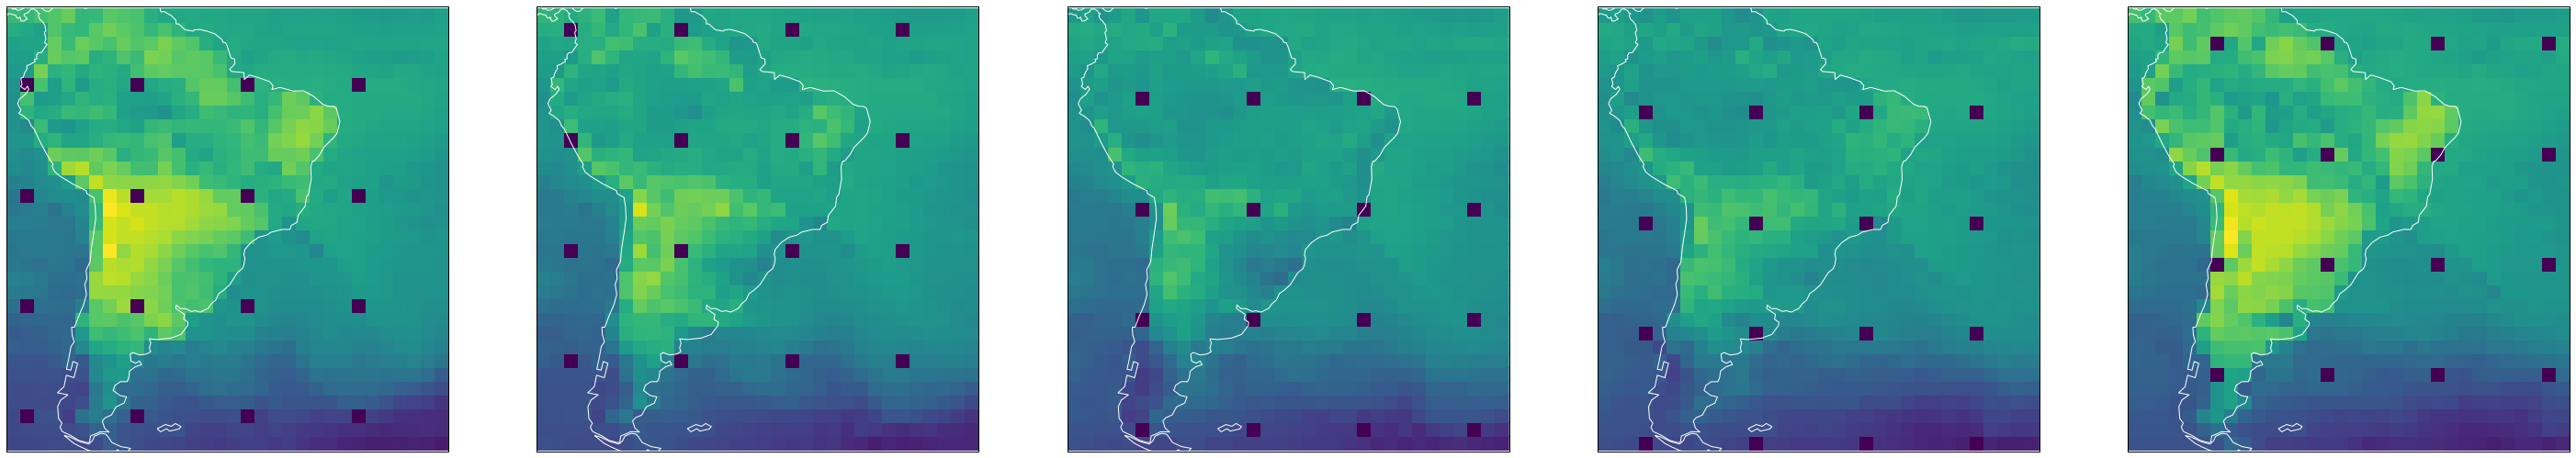

In [106]:
min_val = torch.min(y[0,:,:,:]).cpu()
max_val = torch.max(y[0,:,:,:]).cpu()

fig = plt.figure(figsize=(50, 50))
sst = y[0, 0, :, :].cpu()
lats = dataset.variables['lat'][:]
lons = dataset.variables['lon'][:]

ax1 = plt.subplot(1, 5, 1, projection=ccrs.PlateCarree())
ax1.pcolormesh(lon_pcolormesh_midpoints, lat_pcolormesh_midpoints, sst,
             transform=ccrs.PlateCarree(), vmin=min_val, vmax=max_val)
ax1.coastlines(color='white')
ax1.set_extent([-83,-19,-51,8])

sst = y[0, 1, :, :].cpu()
ax2 = plt.subplot(1, 5, 2, projection=ccrs.PlateCarree())
ax2.pcolormesh(lon_pcolormesh_midpoints, lat_pcolormesh_midpoints, sst,
             transform=ccrs.PlateCarree(), vmin=min_val, vmax=max_val)
ax2.coastlines(color='white')
ax2.set_extent([-83,-19,-51,8])

sst = y[0, 2, :, :].cpu()
ax3 = plt.subplot(1, 5, 3, projection=ccrs.PlateCarree())
ax3.pcolormesh(lon_pcolormesh_midpoints, lat_pcolormesh_midpoints, sst,
             transform=ccrs.PlateCarree(), vmin=min_val, vmax=max_val)
ax3.coastlines(color='white')
ax3.set_extent([-83,-19,-51,8])

sst = y[0, 3, :, :].cpu()
ax4 = plt.subplot(1, 5, 4, projection=ccrs.PlateCarree())
ax4.pcolormesh(lon_pcolormesh_midpoints, lat_pcolormesh_midpoints, sst,
             transform=ccrs.PlateCarree(), vmin=min_val, vmax=max_val)
ax4.coastlines(color='white')
ax4.set_extent([-83,-19,-51,8])

sst = y[0, 4, :, :].cpu()
ax5 = plt.subplot(1, 5, 5, projection=ccrs.PlateCarree())
ax5.pcolormesh(lon_pcolormesh_midpoints, lat_pcolormesh_midpoints, sst,
             transform=ccrs.PlateCarree(), vmin=min_val, vmax=max_val)
ax5.coastlines(color='white')
ax5.set_extent([-83,-19,-51,8])
fig.tight_layout()
plt.show()

In [107]:

print(y[0,0,0,:])

tensor([ 9.2500,  9.2500,  9.4500,  9.7500, 10.0500,  9.5500,  9.8500, 12.5500,
        11.4500, 10.4500,  9.4500,  9.1500,  8.8500,  8.4500,  7.6500,  7.2500,
         7.6500,  8.1500,  7.9500,  7.3500,  7.6500,  6.5500,  5.4500,  5.4500,
         4.6500,  4.2500,  3.7500,  3.8500,  4.0500,  4.2500,  3.9500,  3.5500],
       device='cuda:0')


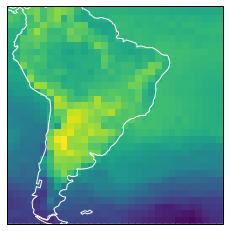

In [86]:
min_val = torch.min(y[0,0,:,:]).cpu()
max_val = torch.max(y[0,0,:,:]).cpu()

sst = z[0, 0, :, :].cpu()
lats = dataset.variables['lat'][:]
lons = dataset.variables['lon'][:]

ax1 = plt.axes(projection=ccrs.PlateCarree())
ax1.pcolormesh(lon_pcolormesh_midpoints, lat_pcolormesh_midpoints, sst,
             transform=ccrs.PlateCarree(), vmin=min_val, vmax=max_val)
ax1.coastlines(color='white')
#[-83,-25,-51.5,8]
ax1.set_extent([-83,-19,-51,8])

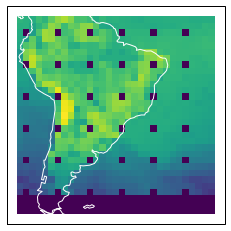

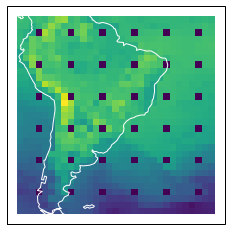

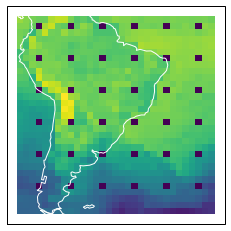

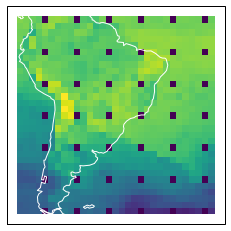

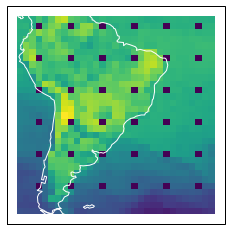

In [121]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import cartopy
#sample, ch, time, lat, lon
sst = y[0, 0, 0, :, :].cpu()
lats = dataset.variables['lat'][:]
lons = dataset.variables['lon'][:]

ax = plt.axes(projection=ccrs.PlateCarree())
plt.pcolormesh(lons, lats, sst,
             transform=ccrs.PlateCarree())
ax.coastlines(color='white')
plt.show()

sst = y[0, 0, 1, :, :].cpu()
lats = dataset.variables['lat'][:]
lons = dataset.variables['lon'][:]

ax = plt.axes(projection=ccrs.PlateCarree())
plt.pcolormesh(lons, lats, sst,
             transform=ccrs.PlateCarree())
ax.coastlines(color='white')

plt.show()

sst = y[0, 0, 2, :, :].cpu()
lats = dataset.variables['lat'][:]
lons = dataset.variables['lon'][:]

ax = plt.axes(projection=ccrs.PlateCarree())
plt.pcolormesh(lons, lats, sst,
             transform=ccrs.PlateCarree())
ax.coastlines(color='white')
plt.show()

sst = y[0, 0, 3, :, :].cpu()
lats = dataset.variables['lat'][:]
lons = dataset.variables['lon'][:]

ax = plt.axes(projection=ccrs.PlateCarree())
plt.pcolormesh(lons, lats, sst,
             transform=ccrs.PlateCarree())
ax.coastlines(color='white')
plt.show()

sst = y[0, 0, 4, :, :].cpu()
lats = dataset.variables['lat'][:]
lons = dataset.variables['lon'][:]

ax = plt.axes(projection=ccrs.PlateCarree())
plt.pcolormesh(lons, lats, sst,
             transform=ccrs.PlateCarree())
ax.coastlines(color='white')
plt.show()

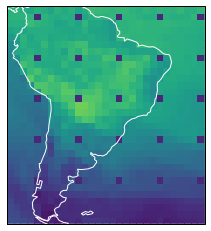

In [50]:
sst = y[0, 0, 0, :, :].cpu()
lats = dataset.variables['lat'][:]
lons = dataset.variables['lon'][:]

ax1 = plt.axes(projection=ccrs.PlateCarree())
ax1.pcolormesh(lon_pcolormesh_midpoints, lat_pcolormesh_midpoints, sst,
             transform=ccrs.PlateCarree(), vmin=min_val, vmax=max_val)
ax1.coastlines(color='white')
ax1.set_extent([-83,-25,-51.5,8])

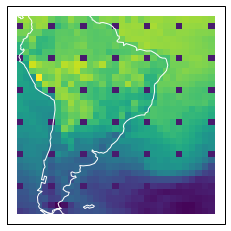

In [81]:
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
fig, axs = plt.subplots(1, 1)
z_min = torch.min(y[0, 0, 0, :, :]).cpu()
z_max = torch.max(y[0, 0, 0, :, :]).cpu()

sst = y[0, 0, 0, :, :].cpu()
lats = dataset.variables['lat'][:]
lons = dataset.variables['lon'][:]

ax = plt.axes(projection=ccrs.PlateCarree())
h = plt.pcolormesh(lons, lats, sst,
             transform=ccrs.PlateCarree(),vmin=z_min, vmax=z_max)
ax.coastlines(color='white')
plt.show()

In [20]:
lat = dataset.variables['lat'][:]
lon = dataset.variables['lon'][:]
# extend longitude by 2
lon_extend = np.zeros(lon.size+2)
# fill in internal values
lon_extend[1:-1] = lon # fill up with original values
# fill in extra endpoints
lon_extend[0] = lon[0]-np.diff(lon)[0]
lon_extend[-1] = lon[-1]+np.diff(lon)[-1]
# calculate the midpoints
lon_pcolormesh_midpoints = lon_extend[:-1]+0.5*(np.diff(lon_extend))

# extend latitude by 2
lat_extend = np.zeros(lat.size+2)
# fill in internal values
lat_extend[1:-1] = lat
# fill in extra endpoints
lat_extend[0] = lat[0]-np.diff(lat)[0]
lat_extend[-1] = lat[-1]+np.diff(lat)[-1]
# calculate the midpoints
lat_pcolormesh_midpoints = lat_extend[:-1]+0.5*(np.diff(lat_extend))


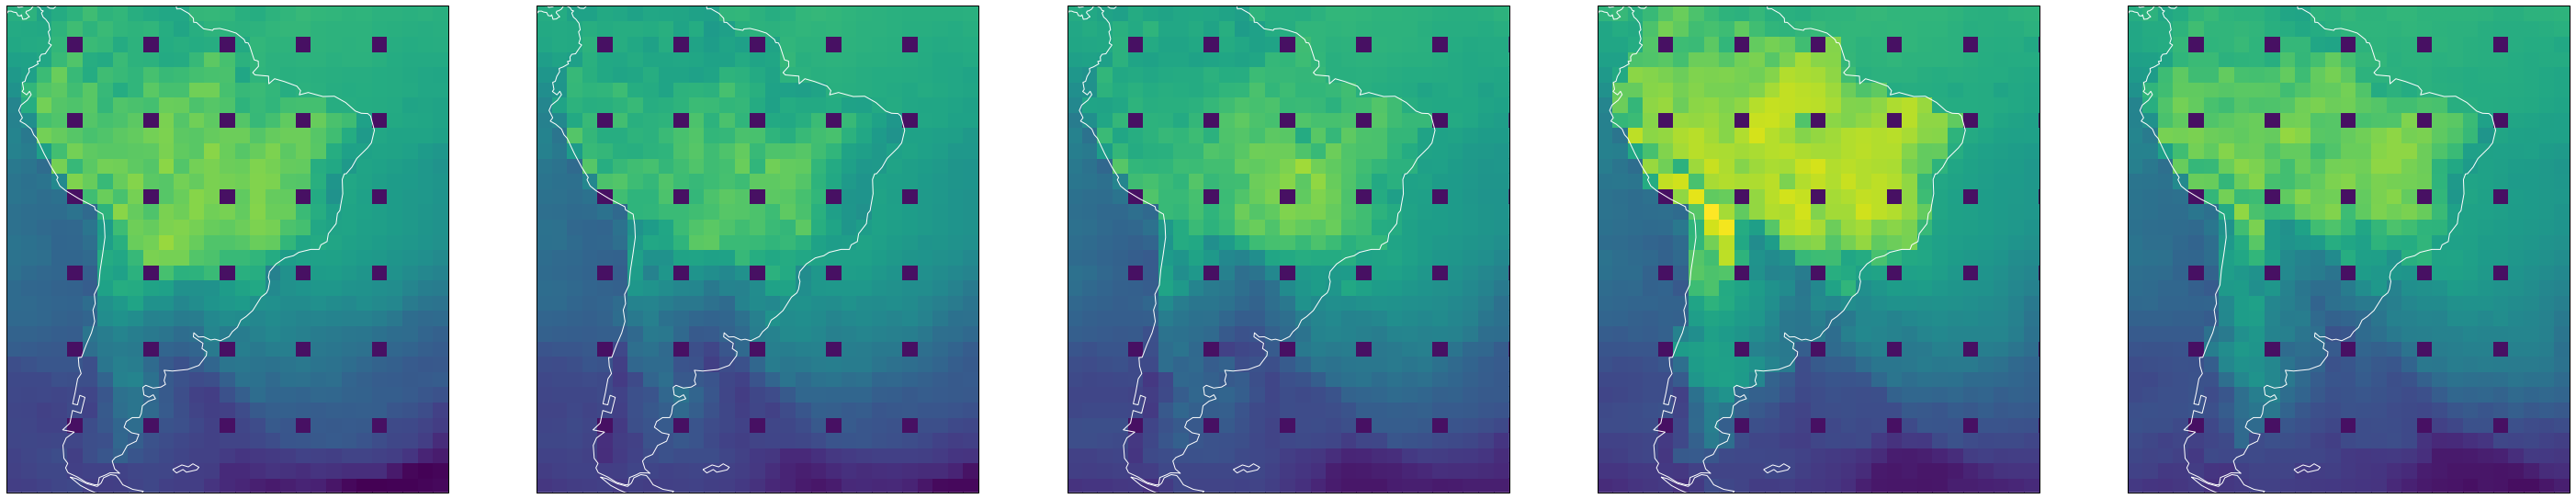

In [95]:
min_val = torch.min(y[0,0,:,:,:]).cpu()
max_val = torch.max(y[0,0,:,:,:]).cpu()

fig = plt.figure(figsize=(50, 50))
sst = y[0, 0, 0, :, :].cpu()
lats = dataset.variables['lat'][:]
lons = dataset.variables['lon'][:]

ax1 = plt.subplot(1, 5, 1, projection=ccrs.PlateCarree())
ax1.pcolormesh(lon_pcolormesh_midpoints, lat_pcolormesh_midpoints, sst,
             transform=ccrs.PlateCarree(), vmin=min_val, vmax=max_val)
ax1.coastlines(color='white')
ax1.set_extent([-83,-25,-51.5,8])

sst = y[0, 0, 1, :, :].cpu()
ax2 = plt.subplot(1, 5, 2, projection=ccrs.PlateCarree())
ax2.pcolormesh(lon_pcolormesh_midpoints, lat_pcolormesh_midpoints, sst,
             transform=ccrs.PlateCarree(), vmin=min_val, vmax=max_val)
ax2.coastlines(color='white')
ax2.set_extent([-83,-25,-51.5,8])

sst = y[0, 0, 2, :, :].cpu()
ax3 = plt.subplot(1, 5, 3, projection=ccrs.PlateCarree())
ax3.pcolormesh(lon_pcolormesh_midpoints, lat_pcolormesh_midpoints, sst,
             transform=ccrs.PlateCarree(), vmin=min_val, vmax=max_val)
ax3.coastlines(color='white')
ax3.set_extent([-83,-25,-51.5,8])

sst = y[0, 0, 3, :, :].cpu()
ax4 = plt.subplot(1, 5, 4, projection=ccrs.PlateCarree())
ax4.pcolormesh(lon_pcolormesh_midpoints, lat_pcolormesh_midpoints, sst,
             transform=ccrs.PlateCarree(), vmin=min_val, vmax=max_val)
ax4.coastlines(color='white')
ax4.set_extent([-83,-25,-51.5,8])

sst = y[0, 0, 4, :, :].cpu()
ax5 = plt.subplot(1, 5, 5, projection=ccrs.PlateCarree())
ax5.pcolormesh(lon_pcolormesh_midpoints, lat_pcolormesh_midpoints, sst,
             transform=ccrs.PlateCarree(), vmin=min_val, vmax=max_val)
ax5.coastlines(color='white')
ax5.set_extent([-83,-25,-51.5,8])
fig.tight_layout()
plt.show()


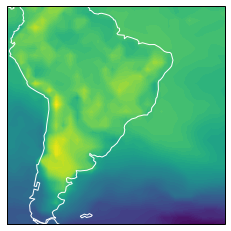

In [14]:
sst = z[0, 0, 0, :, :].cpu()
lats = dataset.variables['lat'][:]
lons = dataset.variables['lon'][:]

ax = plt.axes(projection=ccrs.PlateCarree())

plt.contourf(lons, lats, sst, 60,
             transform=ccrs.PlateCarree())
ax.coastlines(color='white')

plt.show()

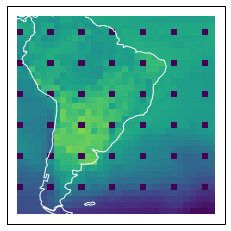

In [171]:
fig,ax = plt.subplots()
sst = y[0, 0, 0, :, :].cpu()
lats = dataset.variables['lat'][:]
lons = dataset.variables['lon'][:]

ax = plt.axes(projection=ccrs.PlateCarree())
ax.xlabel = 'adsadsadsadsada' 
ax.pcolormesh(lon_pcolormesh_midpoints, lat_pcolormesh_midpoints, sst,
             transform=ccrs.PlateCarree(), vmin=min_val, vmax=max_val)
ax.coastlines(color='white')
fig.canvas.draw()
fig.savefig('test.png', bbox_inches='tight')
plt.show()

In [18]:
import math
class Grid(object):
    def __init__(self, d1, d2, ratio = 0.5, mode=0, sequence=2):
        self.d1 = d1
        self.d2 = d2
        self.ratio = ratio
        self.mode=mode
        self.sequence = sequence

    def __call__(self, x):
        c,z,h,w = x.shape
        
        st_s = np.random.randint(z)
        step_s = np.random.randint(1,3)
        y_temp = np.zeros((c,z,h,w))
        
        for j in range(z):
            
            # 1.5 * h, 1.5 * w works fine with the squared images
            # But with rectangular input, the mask might not be able to recover back to the input image shape
            # A square mask with edge length equal to the diagnoal of the input image 
            # will be able to cover all the image spot after the rotation. This is also the minimum square.
            hh = math.ceil((math.sqrt(h*h + w*w + z*z)))

            d = np.random.randint(self.d1, self.d2)
            print(d)
            
            # maybe use ceil? but i guess no big difference
            self.l = math.ceil(d*self.ratio)

            mask = np.ones((hh, hh, hh), np.float32)
            st_h = np.random.randint(d)
            st_w = np.random.randint(d)
            st_z = np.random.randint(d)

            for i in range(-1, hh//d+1):
                s = d*i + st_h
                t = s+self.l
                s = max(min(s, hh), 0)
                t = max(min(t, hh), 0)
                mask[j,s:t,:] *= 0
            for i in range(-1, hh//d+1):
                s = d*i + st_w
                t = s+self.l
                s = max(min(s, hh), 0)
                t = max(min(t, hh), 0)
                mask[j,:,s:t] *= 0
            for i in range(-1, hh//d+1):
                s = d*i + st_z
                t = s+self.l
                s = max(min(s, hh), 0)
                t = max(min(t, hh), 0)
                mask[s:t,:,:] *= 0
            mask = np.asarray(mask)
            print(mask.shape)
            mask = mask[(hh-z)//2:(hh-z)//2+z, (hh-h)//2:(hh-h)//2+h, (hh-w)//2:(hh-w)//2+w]
            mask = mask-1
            print(mask)
            mask = np.reshape(mask, (z,50,50))
            x = x * mask
            #x[:,j,:,:] = x[:,j,:,:] * mask 

        return x

In [19]:
x = np.ones((1,5,50,50))
grid = Grid(5,32, ratio=0.5)
y = grid(x)

TypeError: __init__() missing 1 required positional argument: 'device'

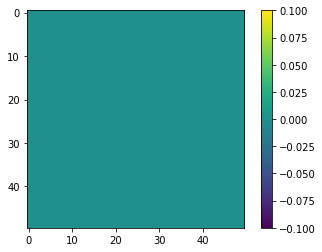

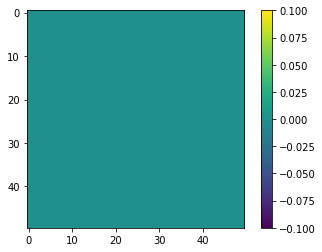

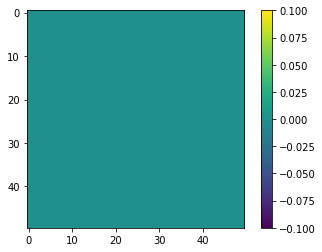

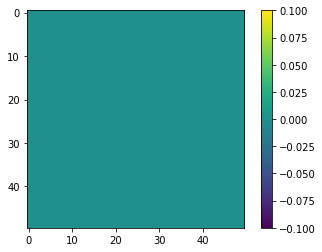

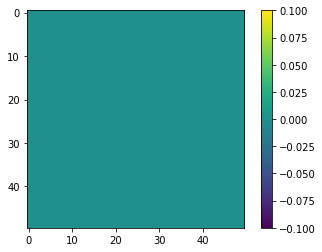

In [17]:
plt.imshow(y[0,0])
plt.colorbar()
plt.show()
plt.imshow(y[0,1])
plt.colorbar()
plt.show()
plt.imshow(y[0,2])
plt.colorbar()
plt.show()
plt.imshow(y[0,3])
plt.colorbar()
plt.show()
plt.imshow(y[0,4])
plt.colorbar()
plt.show()